In [2]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime
import gzip
import matplotlib.gridspec as gridspec

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from methods.raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec


import methods.xflib as xflib

from methods.index_helpers import load_TS_params
from methods.index_helpers import load_Dst
from methods.index_helpers import load_Kp
from methods.index_helpers import load_ae
from methods.index_helpers import Kp_at
from methods.index_helpers import Ae_at

xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/Thesis figures/methods/libxformd.so')

R2D = 180./np.pi
D2R = np.pi/180.
%matplotlib inline
# %matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 18,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

In [66]:

def stix_parameters(ray, t, w = None):

    if w is None:
        w = ray['w']

    B   =  ray['B0'].iloc[t]
    Bmag = np.linalg.norm(B)
    #     print np.linalg.norm(B)
    Q    = np.abs(np.array(ray['qs'].iloc[t,:]))
    M    = np.array(ray['ms'].iloc[t,:])
    Ns   = np.array(ray['Ns'].iloc[t,:])
    n    = (ray['n'].iloc[t])

    Wcs   = Q*Bmag/M
    Wps2  = Ns*pow(Q,2)/eo/M

    R = 1.0 - np.sum(Wps2/(w*(w + Wcs)))
    L = 1.0 - np.sum(Wps2/(w*(w - Wcs)))
    P = 1.0 - np.sum(Wps2/(w*w))
    S = 1.0/(2.0*(R+L))
    D = 1.0/(2.0*(R-L))

    return R, L, P, S, D

In [6]:
# Q_EL = 1.602e-19
# M_EL = 9.1e-31
eo   = 8.854e-12
c    = 2.998e8

# Read in a rayfile -- just to get the plasma density parameters from within
rf = read_rayfile('/shared/users/asousa/WIPP/rays/2d/nightside/mode6/kp0/f_200/lon_0/ray_200_40_0.ray')

(10000,)


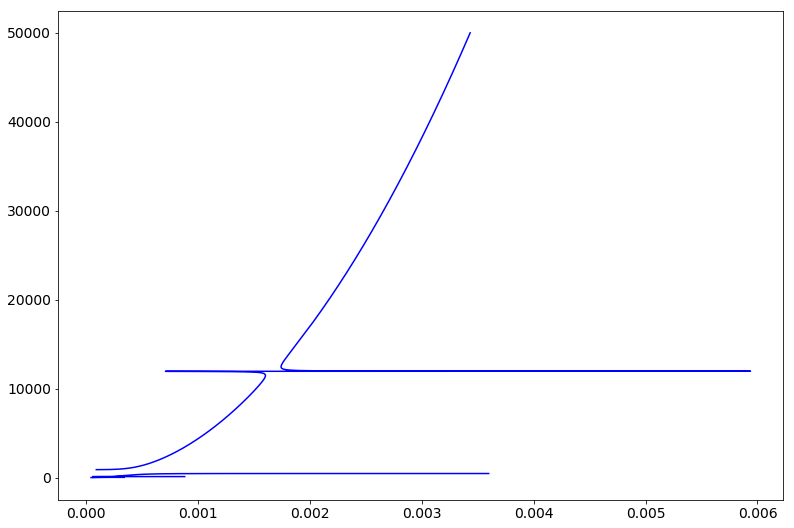

In [123]:

t = 0
ray = rf[0]
# def solve_dispersion_relation(ray, t, root=2, nvec = None):
n = ray['n'].iloc[t]    
B0   =  ray['B0'].iloc[t]
w = ray['w']



fvec = np.array(pow(10, np.linspace(np.log10(5), np.log10(50000), 10000)))

print np.shape(fvec)
roots = np.zeros([len(fvec),4])
for f_ind, f in enumerate(fvec):
    w = 2.0*np.pi*f
    R, L, P, S, D = stix_parameters(ray, t, w)
    
    cos2phi = np.cos(0*D2R)**2 #(np.dot(n, B0)*np.dot(n, B0))/(np.dot(n,n)*np.dot(B0, B0))
    sin2phi = 1.0 - cos2phi

    A = S*sin2phi + P*cos2phi
    B = R*L*sin2phi + P*S*(1.0 + cos2phi)
    discriminant = pow(B,2.0) - 4.0*A*R*L*P
    n1sq = ((B + np.sqrt(discriminant))/(2.0*A))
    n2sq = ((B - np.sqrt(discriminant))/(2.0*A))

    n1 = np.sqrt(n1sq)
    n2 = np.sqrt(n2sq)
    
#     if np.isnan(n1):
#         n1 = np.1*np.sqrt(-1.*n1sq)
#     if np.isnan(n2):
#         n2 = np.1i*np.sqrt(-1.*n2sq)

    if abs(n1) > abs(n2):
        k2 = w*n1/c
        k1 = w*n2/c
    else:
        k1 = w*n1/c
        k2 = w*n2/c
        
    roots[f_ind, :] = [k1, k2, -k1, -k2]


    
fig, ax = plt.subplots(1,1)

# for x in [0,1]:
ax.plot(roots[:,0],fvec, 'r')
ax.plot(roots[:,1],fvec, 'b')
# ax.set_ylim([0,500])

# ax.plot(fvec/2./np.pi, fvec/2./np.pi/roots[:,1])

## This version with Appleton-Hartree alone

[ 0.97571352  0.97571594  0.9757232  ...,  0.9757232   0.97571594
  0.97571352]


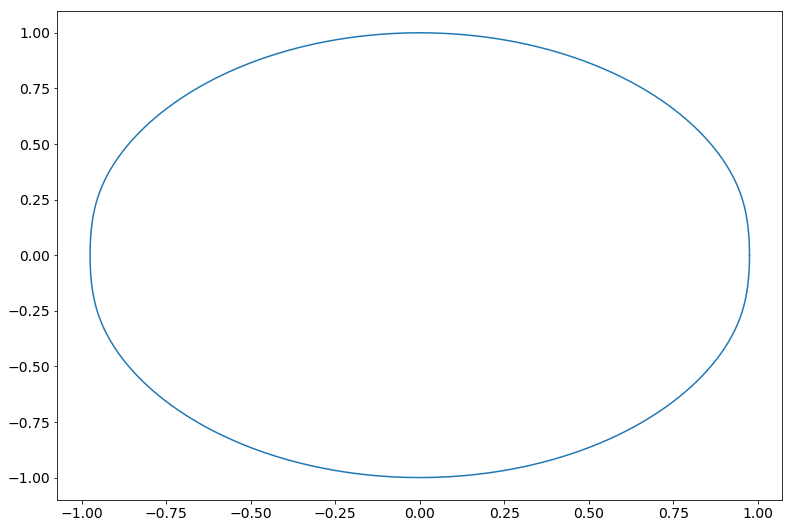

In [65]:
eo   = 8.854e-12
c    = 2.998e8
Q_EL = 1.602e-19
M_EL = 9.1e-31

D2R = np.pi/180.
R2D = 180./np.pi

Ne = (10e-2)*pow(100.,3)
Bmag = 30e-6

f = 200
w = 2.*np.pi*f

theta = np.linspace(0,360, 2000)*D2R

Wc   = Q_EL*Bmag/M_EL
Wc2  = pow(Wc,2)
Wp2  = Ne*pow(Q_EL,2)/eo/M_EL
Wp   = np.sqrt(Wp2)

root = 1.

numerator = Wp2/w/w
denom1 = (Wc2*pow(np.sin(theta),2))/2./(w*w - Wp2)
denom2 = np.sqrt(pow(denom1,2) + Wc2*pow(np.cos(theta), 2)/w/w)
eta2   = (1 - numerator/(1 - denom1 + root*denom2))
eta = np.sqrt(eta2)
print eta
fig, ax = plt.subplots(1,1)
ax.plot(eta*np.cos(theta), eta*np.sin(theta))

## This version with Stix parameters

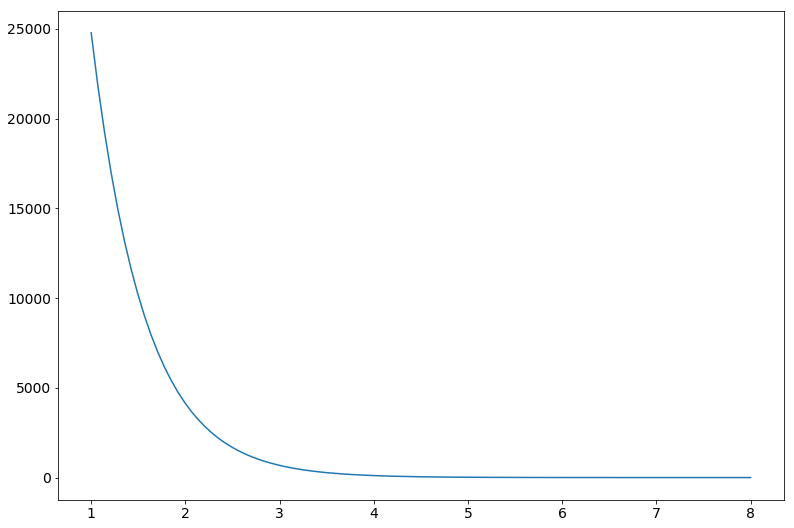

In [110]:
def ne_ps(L, doy, Kp):
#     The Carpenter + Anderson equatorial plasmasphere density
#     profile (Gallagher 2000, equation 5).

    a6 = -0.79
    a7 = 5.208
    a8 = 5.39 - 0.382*Kp;  # Plasmapause location in L (moldwin fit)
    a9 = 0.5  # Slope of plasmapause transition in L (I think)
    rz12 = 0  # mean sunspot number
    
#     ! ---------- Carpenter / Anderson plasmasphere -------------
    h = (1.0 + (L/a8)**(2.0*(a9 - 1)))**(-a9/(a9 - 1.0))
    doy_factor=np.pi*(doy+9.0)/365.0
    x234=( 0.1*(np.cos(2.0*doy_factor) - 0.5*np.cos(4.0*doy_factor))+ (0.00127*rz12-0.0635) ) * np.exp(-(L-2.0)/1.5)

    ne_ps = 10**(a6*L+a7 + x234)

    return ne_ps


Lvec = np.linspace(1,8,100)

fig, ax = plt.subplots(1,1)
ax.plot(Lvec, ne_ps(Lvec,0,0))

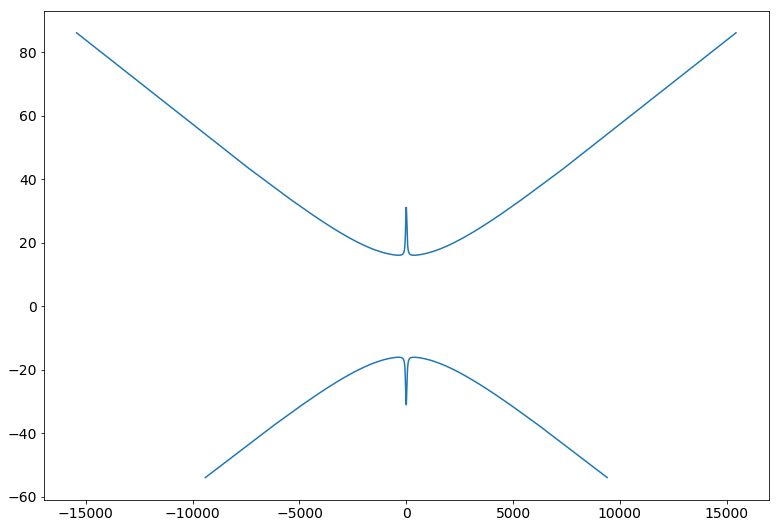

In [513]:
eo   = 8.854e-12
c    = 2.998e8
D2R = np.pi/180.
R2D = 180./np.pi

B0 = 30e-6 # Field at surface, in microtesla
Lshell  = 2 # How far out are we?

# electrons, Hydrogen ions, Helium ions, Oxygen ions
Qvec = np.array([-1,1,1,1])*1.602e-19
Mvec = np.array([9.10938188e-31, 1.6726e-27, 4.0*1.6726e-27, 16.0*1.6726e-27]);
# Ne   = (1e1)*1e6  # Electron density in m^-3
Ne = ne_ps(Lshell,0,0)*1e6
# print "C+A", ne_ps(Lshell, 0,0)*1e6
# print "mine", Ne
Nvec = np.array([1, 0.6, 0.2, 0.2])*Ne # species ratios -- Should remain neutral

f = 200  # Frequency
w = 2.*np.pi*f
phi_vec = np.linspace(0,360,20000)*D2R # Wavenormal angle wrt Magnetic Field

root = -1

k_vec = np.zeros_like(phi_vec)
eta_vec=np.zeros_like(phi_vec)


def stix_parameters_from_values(Q, M, N, Bmag, w):

    Wcs   = Q*Bmag/M
    Wps2  = N*Q*Q/eo/M

    R = 1.0 - np.sum(Wps2/(w*(w + Wcs)))
    L = 1.0 - np.sum(Wps2/(w*(w - Wcs)))
    P = 1.0 - np.sum(Wps2/(w*w))
    S = 0.5*(R+L)
    D = 0.5*(R-L)

    return R, L, P, S, D

Bmag = B0/pow(Lshell - 1, 3)

sR, sL, sP, sS, sD = stix_parameters_from_values(Qvec, Mvec, Nvec, Bmag, w)

for phi_ind, phi  in enumerate(phi_vec):

    # Solve the cold plasma dispersion relation
    cos2phi = pow(np.cos(phi),2)
    sin2phi = pow(np.sin(phi),2)

    A = sS*sin2phi + sP*cos2phi
    B = sR*sL*sin2phi + sP*sS*(1.0+cos2phi)

    discriminant = B*B - 4.0*A*sR*sL*sP

    n1sq = (B + np.sqrt(discriminant))/(2.0*A)
    n2sq = (B - np.sqrt(discriminant))/(2.0*A)

    n1 = np.sqrt(n1sq)
    n2 = np.sqrt(n2sq)

    # Order the roots
    if abs(n1) > abs(n2):
        k2 = w*n1/c
        k1 = w*n2/c
    else:
        k1 = w*n1/c
        k2 = w*n2/c

    if root==1.0:
        k = k1
        eta = n1
    else:
        k = k2
        eta = n2
    k_vec[phi_ind] = k
    eta_vec[phi_ind] = eta

    
# Plot refractive surface:

fig, ax = plt.subplots(1,1)

ax.plot(eta_vec*np.sin(phi_vec), eta_vec*np.cos(phi_vec))




In [698]:
# Define the function:

def form_dispersion_matrix(n2, phi, S, D, P):
    M = np.array([[S - n2*pow(np.cos(phi),2), -1j*D, n2*np.cos(phi)*np.sin(phi)],
                 [1j*D, S - n2, 0],
                 [n2*np.cos(phi)*np.sin(phi), 0, P - n2*pow(np.sin(phi),2)]]);
    return M


def stix_parameters_from_values(Q, M, N, Bmag, w):

    Wcs   = Q*Bmag/M
    Wps2  = N*Q*Q/eo/M

    R = 1.0 - np.sum(Wps2/(w*(w + Wcs)))
    L = 1.0 - np.sum(Wps2/(w*(w - Wcs)))
    P = 1.0 - np.sum(Wps2/(w*w))
    S = 0.5*(R+L)
    D = 0.5*(R-L)

    return R, L, P, S, D

def solve_dispersion_relation(Qvec, Mvec, Nvec, Bmag, w):

#     w = Hz2Rad*f
    sR, sL, sP, sS, sD = stix_parameters_from_values(Qvec, Mvec, Nvec, Bmag, w)

    # Solve the cold plasma dispersion relation
    cos2phi = pow(np.cos(phi),2)
    sin2phi = pow(np.sin(phi),2)

    A = sS*sin2phi + sP*cos2phi
    B = sR*sL*sin2phi + sP*sS*(1.0+cos2phi)
    C = sR*sL*sP
    discriminant = np.sqrt(B*B - 4.0*A*C)
    
    # Two formulations for numerical stability
    if B > 0:
        n1sq = (B + discriminant)/(2.0*A)
        n2sq = (B - discriminant)/(2.0*A)
    else:
        n1sq = 2.0*C/(B - discriminant)
        n2sq = 2.0*C/(B + discriminant)
        
    n1 = np.sqrt(n1sq)
    n2 = np.sqrt(n2sq)

    # Sort by handedness:
    M1 = form_dispersion_matrix(n1sq, phi, sS, sD, sP)    
    U, s, V = np.linalg.svd(M1, full_matrices=True)
    Ee = V[-1,:]
    
    E0 = np.real(Ee)
    E90 = np.imag(Ee)
    angle = np.arctan2(E90[1],E90[0]) - np.arctan2(E0[1],E0[0])
    if angle >= np.pi:
        angle = angle - 2.*np.pi
    elif angle <= -np.pi:
        angle = angle + 2.*np.pi    
    is_right_handed = (angle <= 0.0)

    k1 = w*n1/c
    k2 = w*n2/c
    
    if is_right_handed:
        return np.real(k1), np.real(k2), np.real(n1), np.real(n2)

    else:
        return np.real(k2), np.real(k1), np.real(n2), np.real(n1)

In [708]:
# Compute for parallel case:
eo   = 8.854e-12
c    = 2.998e8
D2R = np.pi/180.
R2D = 180./np.pi
Hz2Rad = 2.*np.pi
Rad2Hz = 1./Hz2Rad

B0 = 30e-6 # Field at surface, in microtesla
Lshell  = 3 # How far out are we?

# electrons, Hydrogen ions, Helium ions, Oxygen ions
Mvec = np.array([9.10938188e-31, 1.6726e-27, 4.0*1.6726e-27, 16.0*1.6726e-27]);

Qvec = np.array([-1,1,1,1])*1.602e-19
# Qvec = np.array([-1,0,0,0])*1.602e-19
# Ne   = (1e1)*1e6  # Electron density in m^-3
Ne = ne_ps(Lshell,0,0)*1e6

Nvec = np.array([1, 0.6, 0.2, 0.2])*Ne # species ratios -- Should remain neutral
# Nvec = np.array([1,0,0,0])*Ne # species ratios -- Should remain neutral

f_vec = pow(10,np.linspace(0, 7, 100000))
w_vec = 2.*np.pi*f_vec

phi = 0*D2R

Bmag = B0/pow(Lshell - 1, 3)


k_vec = np.zeros([len(f_vec),2])
eta_vec=np.zeros([len(f_vec),2])

for w_ind, w  in enumerate(w_vec):

    k1, k2, n1, n2 = solve_dispersion_relation(Qvec, Mvec, Nvec, Bmag, w)
    k_vec[w_ind,:] = k1, k2
    eta_vec[w_ind, :] = n1, n2
    
print "done with full solution"



## Appleton-Hartree solution:
k_vec_AH   = np.zeros([len(f_vec),2])
eta_vec_AH =np.zeros([len(f_vec),2])

Wc   = Q_EL*Bmag/M_EL
Wc2  = pow(Wc,2)
Wp2  = Ne*pow(Q_EL,2)/eo/M_EL
Wp   = np.sqrt(Wp2)


w_vec = 2.*np.pi*f_vec

numerator = Wp2/w_vec/w_vec
denom1 = (Wc2*pow(np.sin(phi),2))/2./(w_vec*w_vec - Wp2)
denom2 = np.sqrt(pow(denom1,2) + Wc2*pow(np.cos(phi), 2)/w_vec/w_vec)
eta2_1   = (1 - numerator/(1 - denom1 + denom2))
eta2_2   = (1 - numerator/(1 - denom1 - denom2))
eta_vec_AH[:,0] = np.sqrt(eta2_1)
eta_vec_AH[:,1] = np.sqrt(eta2_2)

k_vec_AH = eta_vec_AH*w_vec[:,np.newaxis]/c

print "done with Appleton Hartree"

done with full solution
done with Appleton Hartree


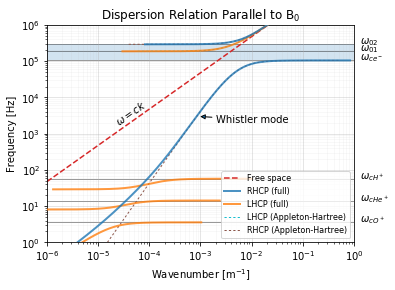

In [727]:
## F vs K plot:

# --------------- Latex Plot Beautification --------------------------
fig_width = 4.5#4 
fig_height = 3#3
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


wc_e = np.abs(Qvec[0]*Bmag/Mvec[0])
wp_e = np.sqrt(Nvec[0]*pow(Qvec[0],2)/eo/Mvec[0])

w01 = 0.5*(-wc + np.sqrt(wc*wc+4.*wp*wp))
w02 = w01 + wc

# f_vec = pow(10,np.linspace(1, 7, 50000))
w = 2.*np.pi*f_vec

n1 = np.sqrt(1 - wp_e*wp_e/(w*(w - wc_e))) # RHCP (whistler mode)
n2 = np.sqrt(1 - wp_e*wp_e/(w*(w + wc_e))) # LHCP 

k1 = w*n1/c
k2 = w*n2/c

kfreespace = w/c

cmap = plt.cm.get_cmap('Vega10')
xlims = [1e-6, 1e0]
ylims = [1e0, 1e6]

fig, ax = plt.subplots(1,1)

# Simplified expressions:
# ax.plot(k1,f_vec)
# ax.plot(k2,f_vec)

# Free space asymptote:
ax.plot(kfreespace,f_vec,linestyle='dashed',c=cmap(3), label='Free space')

# Full solution:
ax.plot(k_vec[:,0],f_vec,linewidth=2, c=cmap(0), label='RHCP (full)', zorder=10, alpha=0.8)    # RHCP
ax.plot(k_vec[:,1],f_vec,linewidth=2, c=cmap(1), label='LHCP (full)', zorder=9,  alpha=0.8)  # LHCP

# Appleton-Hartree solution:
ax.plot(k_vec_AH[:,0],f_vec,'r:',linewidth=1, c=cmap(9), zorder=8, label='LHCP (Appleton-Hartree)')
ax.plot(k_vec_AH[:,1],f_vec,'b:',linewidth=1, c=cmap(5), zorder=8, label='RHCP (Appleton-Hartree)')

# Hand-simplified solution to the full relation:
# ax.plot(k_vec_reduced[:,0],f_vec,'k',linewidth=2)
# ax.plot(k_vec_reduced[:,1],f_vec,'orange',linewidth=2)


# Resonances (cyclotron and plasma for each species):
species = ['e^-','H^+','He^+','O^+']

for i in [0,1,2,3]:
    wc = np.abs(Qvec[i]*Bmag/Mvec[i])
    wp = np.sqrt(Nvec[i]*pow(Qvec[i],2)/eo/Mvec[i])

    w01 = 0.5*(-wc + np.sqrt(wc*wc+4.*wp*wp))
    w02 = w01 + wc
    
    ax.plot(xlims, [Rad2Hz*wc, Rad2Hz*wc],'k', alpha=0.4, linewidth=1, zorder=1)
#     ax.plot(xlims, [Rad2Hz*wp, Rad2Hz*wp],'k', alpha=0.4, linewidth=1, zorder=1)

    if i==0:
        ax.plot(xlims, [Rad2Hz*w01, Rad2Hz*w01],'k', alpha=0.4, linewidth=1, zorder=1)
        ax.plot(xlims, [Rad2Hz*w02, Rad2Hz*w02],'k', alpha=0.4, linewidth=1, zorder=1)
        ax.text(1.3*xlims[-1],Rad2Hz*w01, '$\omega_{01}$')
        ax.text(1.3*xlims[-1],Rad2Hz*w02, '$\omega_{02}$')




    ax.text(1.3*xlims[-1],Rad2Hz*wc, '$\omega_{c%s}$'%species[i])
#     ax.text(1.3*xlims[-1],Rad2Hz*wp, '$\omega_{p%s}$'%species[i])


# Anylitical cutoffs for RHCP:
# ax.plot(xlims, [Rad2Hz*w01, Rad2Hz*w01],'k')
# ax.plot(xlims, [Rad2Hz*w02, Rad2Hz*w02],'k')

# Label the free-space solution
ax.text(2e-5, 5e3,'$\omega=ck$', rotation=35)

# Shade the forbidden region
wc_e = np.abs(Qvec[0]*Bmag/Mvec[0])
wp_e = np.sqrt(Nvec[0]*pow(Qvec[0],2)/eo/Mvec[0])

w01 = 0.5*(-wc_e + np.sqrt(wc_e*wc_e+4.*wp_e*wp_e))
w02 = w01 + wc_e
ax.fill_between(xlims,[Rad2Hz*wc_e,Rad2Hz*wc_e],[Rad2Hz*w02, Rad2Hz*w02], alpha=0.2)

# Point to the Whistler mode:

startpoint = np.array([2e-3, 2e3])
endpoint   = np.array([9e-4, 3e3])

ax.annotate("Whistler mode", xy=(endpoint), xytext=(startpoint),arrowprops=dict(arrowstyle="-|>"))

ax.grid('on',which='major',alpha=0.4)
ax.grid('on',which='minor',alpha=0.1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(xlims)
ax.set_ylim(ylims)

ax.set_xlabel('Wavenumber [m$^{-1}$]')
ax.set_ylabel('Frequency [Hz]')
ax.set_title('Dispersion Relation Parallel to B$_0$')
l = ax.legend(loc='lower right')
l.set_zorder(11)
plt.savefig('omega-k_diagram_parallel.pdf')

In [704]:
## Again, for perpendicular plot:
B0 = 30e-6 # Field at surface, in microtesla
Lshell  = 3 # How far out are we?

# electrons, Hydrogen ions, Helium ions, Oxygen ions
Mvec = np.array([9.10938188e-31, 1.6726e-27, 4.0*1.6726e-27, 16.0*1.6726e-27]);

Qvec = np.array([-1,1,1,1])*1.602e-19
# Qvec = np.array([-1,0,0,0])*1.602e-19
# Ne   = (1e1)*1e6  # Electron density in m^-3
Ne = ne_ps(Lshell,0,0)*1e6

Nvec = np.array([1, 0.6, 0.2, 0.2])*Ne # species ratios -- Should remain neutral
# Nvec = np.array([1,0,0,0])*Ne # species ratios -- Should remain neutral

f_vec = pow(10,np.linspace(0, 7, 20000))
w_vec = 2.*np.pi*f_vec

phi = 45*D2R

Bmag = B0/pow(Lshell - 1, 3)

k_vec = np.zeros([len(f_vec),2])
eta_vec=np.zeros([len(f_vec),2])

for w_ind, w  in enumerate(w_vec):

    k1, k2, n1, n2 = solve_dispersion_relation(Qvec, Mvec, Nvec, Bmag, w)
    k_vec[w_ind,:] = k1, k2
    eta_vec[w_ind, :] = n1, n2
    
print "done with full solution"


## Appleton-Hartree solution:
k_vec_AH   = np.zeros([len(f_vec),2])
eta_vec_AH =np.zeros([len(f_vec),2])

Wc   = Q_EL*Bmag/M_EL
Wc2  = pow(Wc,2)
Wp2  = Ne*pow(Q_EL,2)/eo/M_EL
Wp   = np.sqrt(Wp2)


# w_vec = 2.*np.pi*f_vec

numerator = Wp2/w_vec/w_vec
denom1 = (Wc2*pow(np.sin(phi),2))/2./(w_vec*w_vec - Wp2)
denom2 = np.sqrt(pow(denom1,2) + Wc2*pow(np.cos(phi), 2)/w_vec/w_vec)
eta2_1   = (1 - numerator/(1 - denom1 + denom2))
eta2_2   = (1 - numerator/(1 - denom1 - denom2))
eta_vec_AH[:,0] = np.sqrt(eta2_1)
eta_vec_AH[:,1] = np.sqrt(eta2_2)

k_vec_AH = eta_vec_AH*w_vec[:,np.newaxis]/c

print "done with appleton-hartree"


done with full solution
done with appleton-hartree


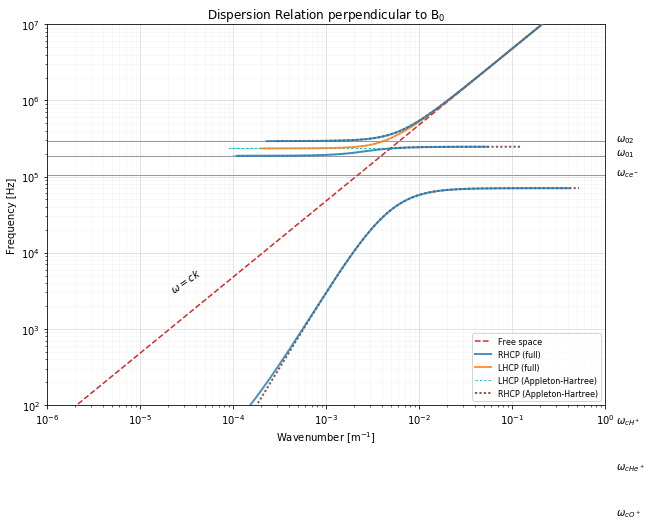

In [705]:
## F vs K plot:

# --------------- Latex Plot Beautification --------------------------
fig_width =  9
fig_height = 6
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


wc_e = np.abs(Qvec[0]*Bmag/Mvec[0])
wp_e = np.sqrt(Nvec[0]*pow(Qvec[0],2)/eo/Mvec[0])

w01 = 0.5*(-wc + np.sqrt(wc*wc+4.*wp*wp))
w02 = w01 + wc

# f_vec = pow(10,np.linspace(1, 7, 50000))
w = 2.*np.pi*f_vec

n1 = np.sqrt(1 - wp_e*wp_e/(w*(w - wc_e))) # RHCP (whistler mode)
n2 = np.sqrt(1 - wp_e*wp_e/(w*(w + wc_e))) # LHCP 

k1 = w*n1/c
k2 = w*n2/c

kfreespace = w/c

cmap = plt.cm.get_cmap('Vega10')
xlims = [1e-6, 1e0]
ylims = [1e2, 1e7]

fig, ax = plt.subplots(1,1)

# Free space asymptote:
ax.plot(kfreespace,f_vec,linestyle='dashed',c=cmap(3), label='Free space')

# Full solution:
ax.plot(k_vec[:,0],f_vec,linewidth=2, c=cmap(0), label='RHCP (full)', zorder=10, alpha=0.8)    # RHCP
ax.plot(k_vec[:,1],f_vec,linewidth=2, c=cmap(1), label='LHCP (full)', zorder=9,  alpha=0.8)  # LHCP

# Appleton-Hartree solution:
ax.plot(k_vec_AH[:,0],f_vec,'r:',linewidth=1, c=cmap(9), zorder=8, label='LHCP (Appleton-Hartree)')
ax.plot(k_vec_AH[:,1],f_vec,'b:',linewidth=2, c=cmap(5), zorder=8, label='RHCP (Appleton-Hartree)')


# Resonances (cyclotron and plasma for each species):
species = ['e^-','H^+','He^+','O^+']

for i in [0,1,2,3]:
    wc = np.abs(Qvec[i]*Bmag/Mvec[i])
    wp = np.sqrt(Nvec[i]*pow(Qvec[i],2)/eo/Mvec[i])

    w01 = 0.5*(-wc + np.sqrt(wc*wc+4.*wp*wp))
    w02 = w01 + wc
    
    ax.plot(xlims, [Rad2Hz*wc, Rad2Hz*wc],'k', alpha=0.4, linewidth=1, zorder=1)
#     ax.plot(xlims, [Rad2Hz*wp, Rad2Hz*wp],'k', alpha=0.4, linewidth=1, zorder=1)

    if i==0:
        ax.plot(xlims, [Rad2Hz*w01, Rad2Hz*w01],'k', alpha=0.4, linewidth=1, zorder=1)
        ax.plot(xlims, [Rad2Hz*w02, Rad2Hz*w02],'k', alpha=0.4, linewidth=1, zorder=1)
        ax.text(1.3*xlims[-1],Rad2Hz*w01, '$\omega_{01}$')
        ax.text(1.3*xlims[-1],Rad2Hz*w02, '$\omega_{02}$')




    ax.text(1.3*xlims[-1],Rad2Hz*wc, '$\omega_{c%s}$'%species[i])
#     ax.text(1.3*xlims[-1],Rad2Hz*wp, '$\omega_{p%s}$'%species[i])

# Label the free-space solution
ax.text(2e-5, 5e3,'$\omega=ck$', rotation=35)

# Shade the forbidden region
wc_e = np.abs(Qvec[0]*Bmag/Mvec[0])
wp_e = np.sqrt(Nvec[0]*pow(Qvec[0],2)/eo/Mvec[0])

w01 = 0.5*(-wc_e + np.sqrt(wc_e*wc_e+4.*wp_e*wp_e))
w02 = w01 + wc_e
# ax.fill_between(xlims,[Rad2Hz*wc_e,Rad2Hz*wc_e],[Rad2Hz*w02, Rad2Hz*w02], alpha=0.2)


ax.grid('on',which='major',alpha=0.4)
ax.grid('on',which='minor',alpha=0.1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(xlims)
ax.set_ylim(ylims)

ax.set_xlabel('Wavenumber [m$^{-1}$]')
ax.set_ylabel('Frequency [Hz]')
ax.set_title('Dispersion Relation perpendicular to B$_0$')
l = ax.legend(loc='lower right')
l.set_zorder(11)
# plt.savefig('omega-k_diagram_perpendicular.pdf')

In [550]:
## My simplified version of the full dispersion relation (parallel prop, electrons only)

Wc   = Qvec[0]*Bmag/Mvec[0] #Q_EL*Bmag/M_EL
Wc2  = pow(Wc,2)
Wp2  = Nvec[0]*pow(Qvec[0],2)/eo/Mvec[0] #Ne*pow(Q_EL,2)/eo/M_EL
Wp   = np.sqrt(Wp2)

w = Hz2Rad*f_vec


n1sq = (w*w - w*Wc - Wp2)/(w*(w+Wc))
n2sq = (w*w + w*Wc - Wp2)/(w*(w-Wc))

eta_vec_reduced = np.zeros_like(eta_vec_AH)
eta_vec_reduced[:,0] = np.sqrt(n1sq)
eta_vec_reduced[:,1] = np.sqrt(n2sq)
k_vec_reduced = eta_vec_reduced*w_vec[:,np.newaxis]/c